In [1]:
!pip uninstall -y torch torchvision torchaudio


!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.41.0

!wget https://github.com/state-spaces/mamba/releases/download/v2.2.2/mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install causal-conv1d>=1.4.0

import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from mamba_ssm.models.mixer_seq_simple import MixerModel
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoModelForCausalLM
from mamba_ssm.models.config_mamba import MambaConfig

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 1.9 MB/s eta 0:00:00:00:01m0:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.5 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 64.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.2 MB/s eta 0:00:00:00:01

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import joblib

# Load data
df = pd.read_csv('/kaggle/input/yahoofi/stock_details_5_years.csv')

# Data cleaning
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Filter for ABC stock
aal_df = df[df['Company'] == 'AAPL'].copy()
aal_df.set_index('Date', inplace=True)

# =============================================
# NEW: Add volatility features BEFORE splitting
# =============================================
aal_df['rolling_std_20'] = aal_df['Close'].rolling(window=5).std()
aal_df['rolling_mean_20'] = aal_df['Close'].rolling(window=5).mean()
aal_df['price_ratio'] = aal_df['Close'] / aal_df['rolling_mean_20']

# Handle NaN values from rolling windows
aal_df = aal_df.dropna()

# =============================================
# Feature selection (updated with new features)
# =============================================
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'rolling_std_20', 'rolling_mean_20', 'price_ratio']  # Added new features
target_col = 'Close'

features = aal_df[feature_cols].values.astype(np.float32)
target = aal_df[target_col].values.astype(np.float32)

# Normalization
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Save scalers
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

# Sequence creation (unchanged)
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)

# Train/val/test split (unchanged)
total_size = len(X)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Convert to tensors (unchanged)
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# DataLoaders (unchanged)
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_35/2569569998.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [64]:
import torch
import torch.nn as nn

class Add_Norm(nn.Module):
    def __init__(self, d_model, dropout, residual=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.residual = residual
    
    def forward(self, new, old):
        if self.residual:
            return self.norm(old + self.dropout(new))
        return self.norm(self.dropout(new))

class BimambaEncoderLayer(nn.Module):
    def __init__(self, d_model, d_conv, d_state, expand, 
                 b_d_conv, b_d_state, b_expand, dropout, d_ff, 
                 activation="relu", residual=True):
        super().__init__()
        # Mamba blocks (assumed defined elsewhere)
        self.mamba_forward = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        )
        self.mamba_backward = Mamba(
            d_model=d_model, d_state=b_d_state, d_conv=b_d_conv, expand=b_expand
        )
        # Normalization (pre-norm)
        self.norm = nn.LayerNorm(d_model)
        # Add/Norm layers
        self.addnorm1 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm2 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm3 = Add_Norm(d_model, dropout, residual=residual)
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.addnorm4 = Add_Norm(d_model, dropout, residual=residual)

    def forward(self, x, mask=None):
        x_norm = self.norm(x)
        
        # Forward Mamba block
        out_fwd = self.mamba_forward(x_norm)
        out_fwd = self.addnorm1(out_fwd, x)  # residual=False
        
        # Backward Mamba block
        rev_input = x_norm.flip(dims=[1])
        # rev_mask = mask.flip(dims=[1]) if mask is not None else None  # Not used because Mamba lacks mask support
        
        out_bwd = self.mamba_backward(rev_input)  # no mask passed
        out_bwd = out_bwd.flip(dims=[1])
        out_bwd = self.addnorm2(out_bwd, x)  # residual=False
        
        # Combine forward and backward outputs
        out = out_fwd + out_bwd
        out = self.addnorm3(out, x)  # residual=True
        
        # Feed Forward Network
        ffn_out = self.ffn(out)
        return self.addnorm4(ffn_out, out)  # residual=True

class StockMambaEncoder(nn.Module):
    def __init__(self, input_features=8, d_model=64, n_layer=2, 
                 d_conv=2, d_state=16, expand=2, 
                 b_d_conv=2, b_d_state=16, b_expand=2,
                 dropout=0.1, d_ff=512):
        super().__init__()
        # Input projection
        self.input_proj = nn.Linear(input_features, d_model)
        # Encoder layers
        self.layers = nn.ModuleList([
            BimambaEncoderLayer(
                d_model=d_model, d_conv=d_conv, d_state=d_state, expand=expand,
                b_d_conv=b_d_conv, b_d_state=b_d_state, b_expand=b_expand,
                dropout=dropout, d_ff=d_ff
            ) for _ in range(n_layer)
        ])
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        #print(x.shape)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)  # mask is accepted but not used for now
        return x


In [65]:
import math
import torch
import torch.nn as nn


class StockMambaDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        d_conv,
        d_state,
        expand,
        n_heads, 
        dropout,
        d_ff,
        activation="relu"  # Added activation parameter
    ):
        super().__init__()
        
        # Causal Mamba layer with residual connection
        self.causal_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Enhanced cross-attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # Improved FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, target, encoder_output, src_mask=None):
        # 1. Causal Mamba block
        residual = target
        target = self.norm1(target)
        target = residual + self.dropout1(self.causal_mamba(target))
        
        # 2. Cross-attention block
        residual = target
        target = self.norm2(target)
        attn_out, attn_weights = self.cross_attn(
            query=target,
            key=encoder_output,
            value=encoder_output,
            key_padding_mask=src_mask  # True = ignore/mask
        )
        target = residual + self.dropout2(attn_out)
        
        # 3. FFN block
        residual = target
        target = self.norm3(target)
        target = residual + self.dropout3(self.ffn(target))
        
        return target, attn_weights


class StockMambaDecoder(nn.Module):
    def __init__(self,
                 d_model=64,
                 d_conv=2,
                 d_state=16,
                 expand=2,
                 n_heads=4,
                 n_layer=2,
                 dropout=0.1,
                 d_ff=256,
                 input_dim=1,
                 output_dim=1,
                 pred_length=PRED_LENGTH):  # Added prediction length
        super().__init__()
        self.pred_length = pred_length
        
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Decoder layers
        self.layers = nn.ModuleList([
            StockMambaDecoderLayer(
                d_model=d_model,
                d_conv=d_conv,
                d_state=d_state,
                expand=expand,
                n_heads=n_heads,
                dropout=dropout,
                d_ff=d_ff,
                activation="relu"
            ) for _ in range(n_layer)
        ])
        
        # Multi-step output projection
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim),  # Predict all steps at once
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=nn.init.calculate_gain('relu'))

    def forward(self, target, encoder_output, tgt_mask=None, src_mask=None):
        # 1. Project input
        x = self.input_proj(target)
        

        # 2. Zero out padding positions (masked tokens) in decoder input
        if tgt_mask is not None:
            x = x.masked_fill(tgt_mask.unsqueeze(-1), 0.0)


        # 3. Decoder layers
        attn_weights = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, src_mask=src_mask)
            attn_weights.append(attn)

        # 4. Output projection to predict all steps at once
        predictions = self.output_proj(x) 
        
        #predictions = predictions[:, -self.pred_length:, :]
        return predictions.squeeze(-1), attn_weights


Epoch 1/30: 100%|██████████| 12/12 [00:00<00:00, 129.72it/s]


Epoch 1: Train Loss=0.4004, Val Loss=0.2616, Val RMSE=0.8772
-> Saved Best Model


Epoch 2/30: 100%|██████████| 12/12 [00:00<00:00, 131.56it/s]


Epoch 2: Train Loss=0.1509, Val Loss=0.1096, Val RMSE=0.5145
-> Saved Best Model


Epoch 3/30: 100%|██████████| 12/12 [00:00<00:00, 131.96it/s]


Epoch 3: Train Loss=0.1618, Val Loss=0.7351, Val RMSE=1.7640


Epoch 4/30: 100%|██████████| 12/12 [00:00<00:00, 133.26it/s]


Epoch 4: Train Loss=0.2070, Val Loss=0.0650, Val RMSE=0.3655
-> Saved Best Model


Epoch 5/30: 100%|██████████| 12/12 [00:00<00:00, 131.16it/s]


Epoch 5: Train Loss=0.0839, Val Loss=0.0442, Val RMSE=0.3049
-> Saved Best Model


Epoch 6/30: 100%|██████████| 12/12 [00:00<00:00, 129.87it/s]


Epoch 6: Train Loss=0.0526, Val Loss=0.0352, Val RMSE=0.2691
-> Saved Best Model


Epoch 7/30: 100%|██████████| 12/12 [00:00<00:00, 128.09it/s]


Epoch 7: Train Loss=0.0806, Val Loss=0.0520, Val RMSE=0.3308


Epoch 8/30: 100%|██████████| 12/12 [00:00<00:00, 129.05it/s]


Epoch 8: Train Loss=0.0619, Val Loss=0.0502, Val RMSE=0.3206


Epoch 9/30: 100%|██████████| 12/12 [00:00<00:00, 129.57it/s]


Epoch 9: Train Loss=0.0605, Val Loss=0.1520, Val RMSE=0.5697


Epoch 10/30: 100%|██████████| 12/12 [00:00<00:00, 131.36it/s]


Epoch 10: Train Loss=0.0315, Val Loss=0.0187, Val RMSE=0.1934
-> Saved Best Model


Epoch 11/30: 100%|██████████| 12/12 [00:00<00:00, 129.14it/s]


Epoch 11: Train Loss=0.0265, Val Loss=0.0195, Val RMSE=0.1991


Epoch 12/30: 100%|██████████| 12/12 [00:00<00:00, 122.91it/s]


Epoch 12: Train Loss=0.0358, Val Loss=0.0677, Val RMSE=0.3700


Epoch 13/30: 100%|██████████| 12/12 [00:00<00:00, 128.60it/s]


Epoch 13: Train Loss=0.0470, Val Loss=0.0150, Val RMSE=0.1735
-> Saved Best Model


Epoch 14/30: 100%|██████████| 12/12 [00:00<00:00, 129.56it/s]


Epoch 14: Train Loss=0.0104, Val Loss=0.0294, Val RMSE=0.2424


Epoch 15/30: 100%|██████████| 12/12 [00:00<00:00, 133.44it/s]


Epoch 15: Train Loss=0.0192, Val Loss=0.0637, Val RMSE=0.3591


Epoch 16/30: 100%|██████████| 12/12 [00:00<00:00, 132.98it/s]


Epoch 16: Train Loss=0.0197, Val Loss=0.0766, Val RMSE=0.3930


Epoch 17/30: 100%|██████████| 12/12 [00:00<00:00, 126.02it/s]


Epoch 17: Train Loss=0.0205, Val Loss=0.0505, Val RMSE=0.3183


Epoch 18/30: 100%|██████████| 12/12 [00:00<00:00, 130.69it/s]


Epoch 18: Train Loss=0.0144, Val Loss=0.0131, Val RMSE=0.1624
-> Saved Best Model


Epoch 19/30: 100%|██████████| 12/12 [00:00<00:00, 106.34it/s]


Epoch 19: Train Loss=0.0077, Val Loss=0.0096, Val RMSE=0.1389
-> Saved Best Model


Epoch 20/30: 100%|██████████| 12/12 [00:00<00:00, 121.50it/s]


Epoch 20: Train Loss=0.0084, Val Loss=0.0081, Val RMSE=0.1271
-> Saved Best Model


Epoch 21/30: 100%|██████████| 12/12 [00:00<00:00, 128.18it/s]


Epoch 21: Train Loss=0.0047, Val Loss=0.0040, Val RMSE=0.0901
-> Saved Best Model


Epoch 22/30: 100%|██████████| 12/12 [00:00<00:00, 128.83it/s]


Epoch 22: Train Loss=0.0051, Val Loss=0.0038, Val RMSE=0.0871
-> Saved Best Model


Epoch 23/30: 100%|██████████| 12/12 [00:00<00:00, 128.25it/s]


Epoch 23: Train Loss=0.0042, Val Loss=0.0058, Val RMSE=0.1078


Epoch 24/30: 100%|██████████| 12/12 [00:00<00:00, 130.45it/s]


Epoch 24: Train Loss=0.0053, Val Loss=0.0058, Val RMSE=0.1085


Epoch 25/30: 100%|██████████| 12/12 [00:00<00:00, 126.54it/s]


Epoch 25: Train Loss=0.0050, Val Loss=0.0048, Val RMSE=0.0983


Epoch 26/30: 100%|██████████| 12/12 [00:00<00:00, 130.25it/s]


Epoch 26: Train Loss=0.0039, Val Loss=0.0036, Val RMSE=0.0851
-> Saved Best Model


Epoch 27/30: 100%|██████████| 12/12 [00:00<00:00, 116.85it/s]


Epoch 27: Train Loss=0.0045, Val Loss=0.0041, Val RMSE=0.0909


Epoch 28/30: 100%|██████████| 12/12 [00:00<00:00, 131.46it/s]


Epoch 28: Train Loss=0.0031, Val Loss=0.0035, Val RMSE=0.0837
-> Saved Best Model


Epoch 29/30: 100%|██████████| 12/12 [00:00<00:00, 131.87it/s]


Epoch 29: Train Loss=0.0033, Val Loss=0.0063, Val RMSE=0.1131


Epoch 30/30: 100%|██████████| 12/12 [00:00<00:00, 122.94it/s]


Epoch 30: Train Loss=0.0046, Val Loss=0.0038, Val RMSE=0.0880


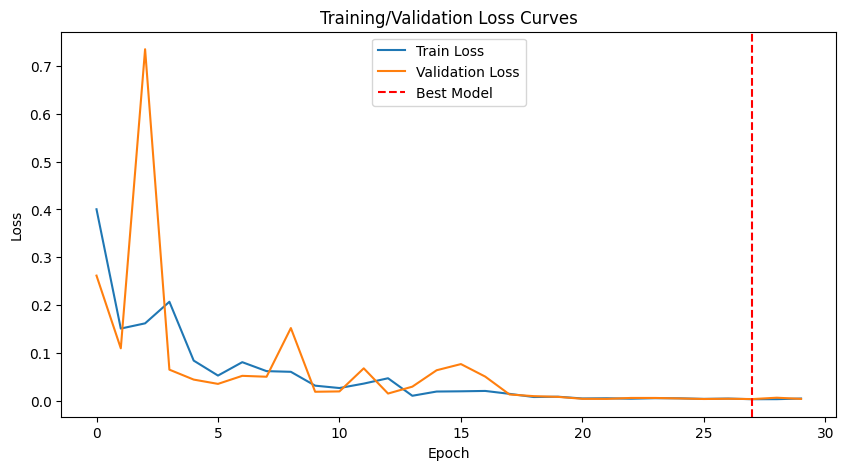

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Loss Function
class StockLoss(nn.Module):
    def __init__(self, delta=0.5, direction_weight=0.6, margin=0.02):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta)
        self.direction_weight = direction_weight
        self.margin = margin
        
    def forward(self, preds, targets):
        # Base regression loss
        huber_loss = self.huber(preds, targets)
        
        # Directional loss only for multi-step predictions
        if preds.size(1) > 1:
            pred_dirs = preds[:, 1:] - preds[:, :-1]
            true_dirs = targets[:, 1:] - targets[:, :-1]
            
            # Only consider significant movements
            significant_moves = (true_dirs.abs() > self.margin).float()
            dir_accuracy = torch.sign(pred_dirs * true_dirs)
            
            # Loss for wrong directions on significant moves
            dir_loss = torch.mean(torch.relu(-dir_accuracy * significant_moves))
        else:
            dir_loss = torch.tensor(0.0, device=preds.device)
            
        return huber_loss + self.direction_weight * dir_loss

# Initialize your existing encoder (unchanged)
encoder = StockMambaEncoder(input_features=8, d_model=64)
decoder = StockMambaDecoder(pred_length=PRED_LENGTH)
model = nn.ModuleDict({'encoder': encoder, 'decoder': decoder}).to(device)

# Stronger regularization in optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02).to(device)

best_val_loss = float('inf')
no_improve = 0
patience = 5
train_losses = []
val_losses = []
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_losses = []
    
    # Data augmentation with Gaussian noise
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)
        
        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        
        preds, _ = model['decoder'](decoder_input, enc_out)
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter clipping
        optimizer.step()
        
        epoch_train_losses.append(loss.item())


    
    # Validation
    losses = []
    all_preds = []
    all_targets = []
    for batch_X, batch_y in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)

        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        preds, _ = model['decoder'](decoder_input, enc_out)
        all_preds.append(preds.squeeze(1).detach().cpu().numpy())
        all_targets.append(batch_y.squeeze(-1).detach().cpu().numpy())
        loss = criterion(preds, batch_y.squeeze(-1))
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss=avg_loss
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    scheduler.step(val_loss)
    
    # Track losses
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_mamba_stock.pth")
        print("-> Saved Best Model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing: 100%|██████████| 12/12 [00:00<00:00, 156.51it/s]


Original mean: $119.23
Original std: $46.86


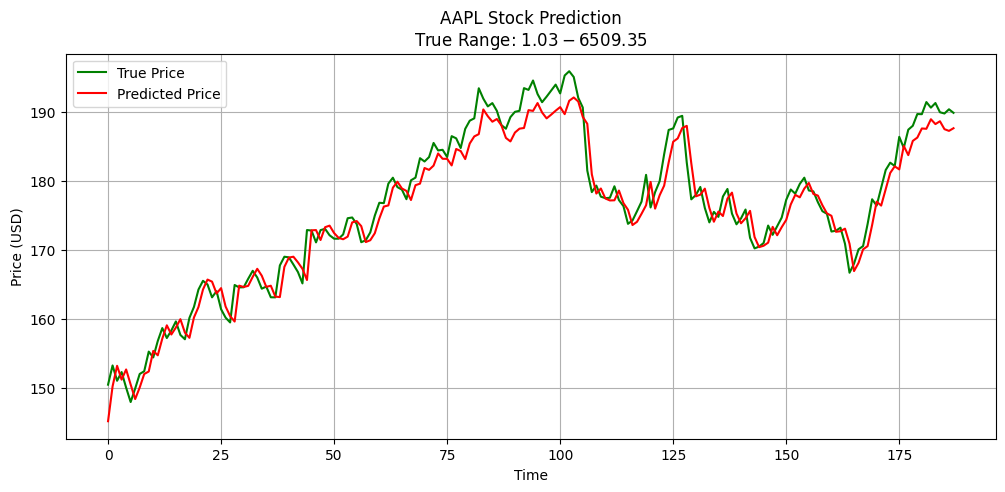


Normalized Metrics:
RMSE: 0.0529
MAE: 0.0425
R²: 0.9520

Denormalized Metrics (USD):
RMSE: $2.48 (2.1% of mean price)
MAE: $1.99
MAPE (>$5 prices): 1.12%


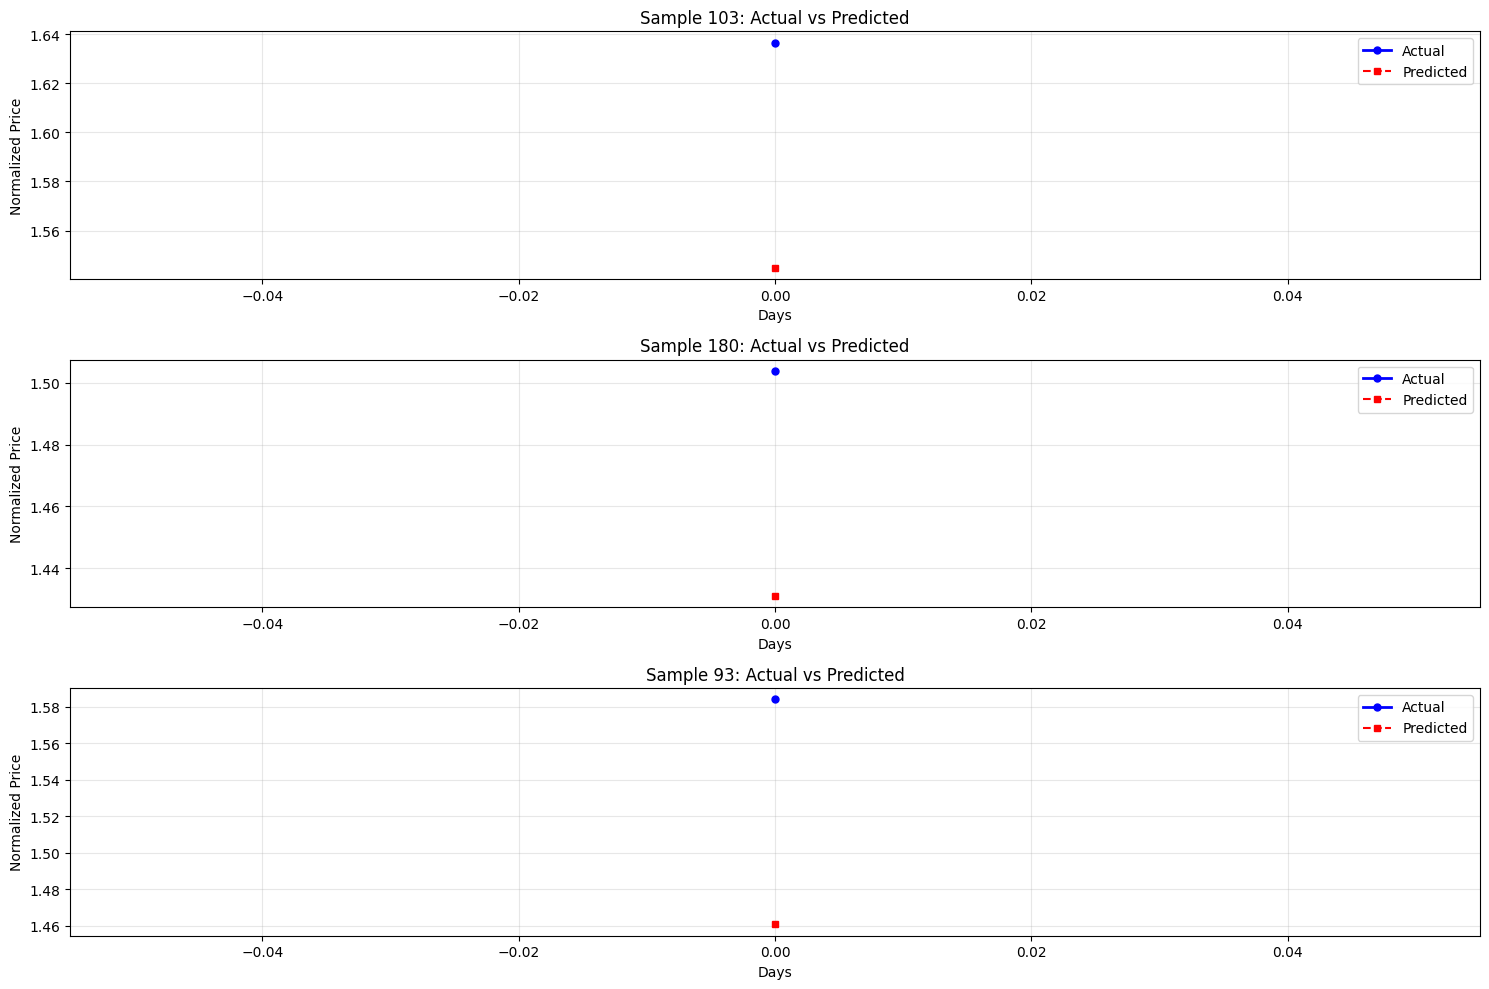

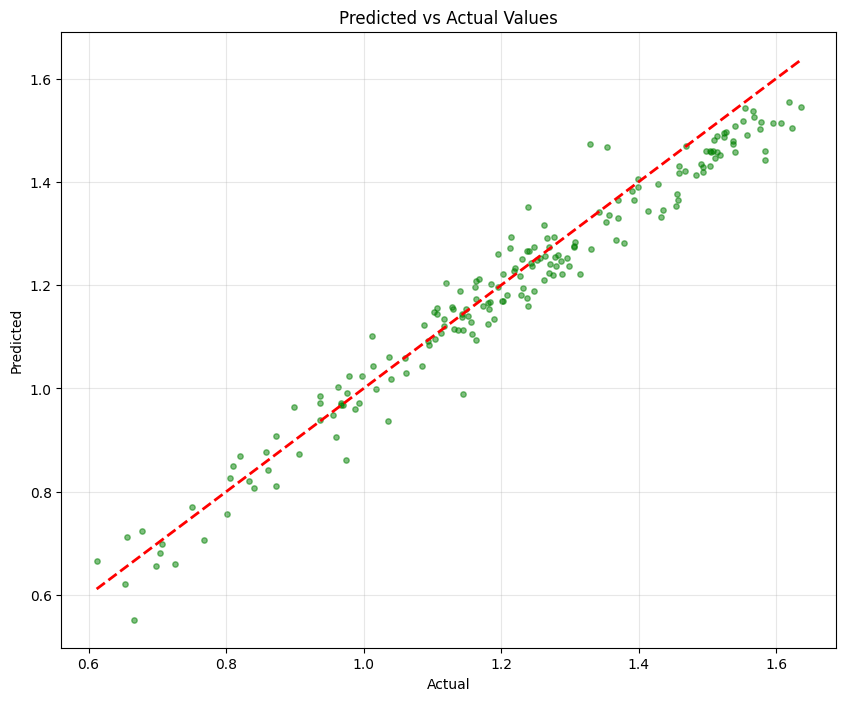

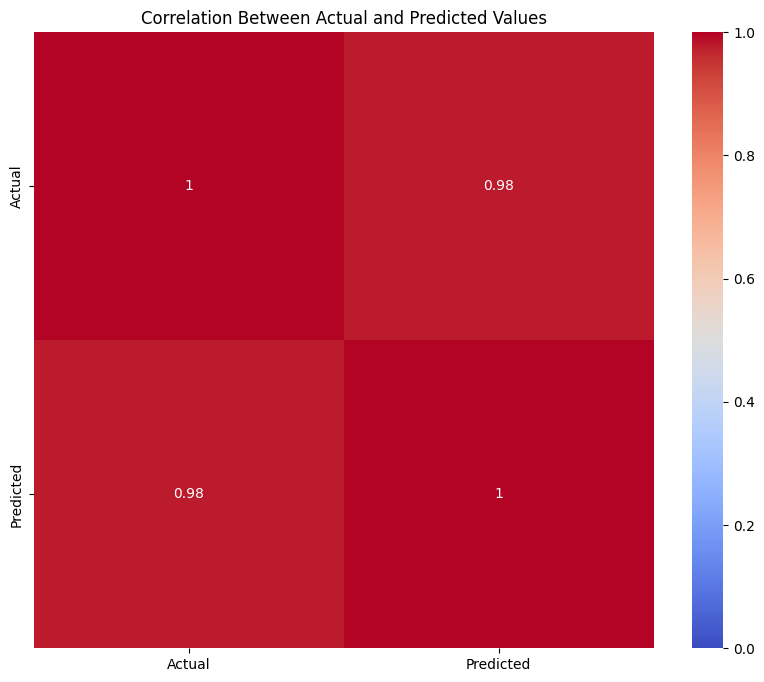

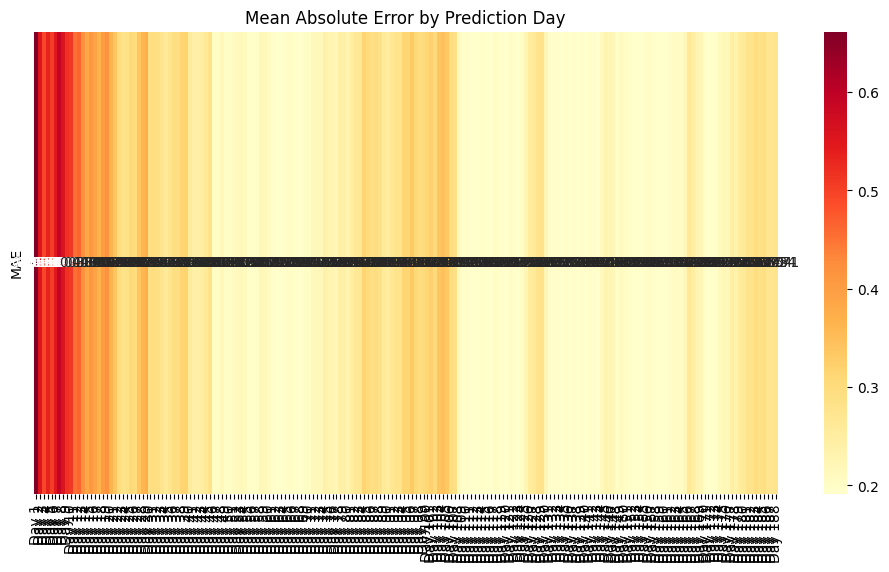

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


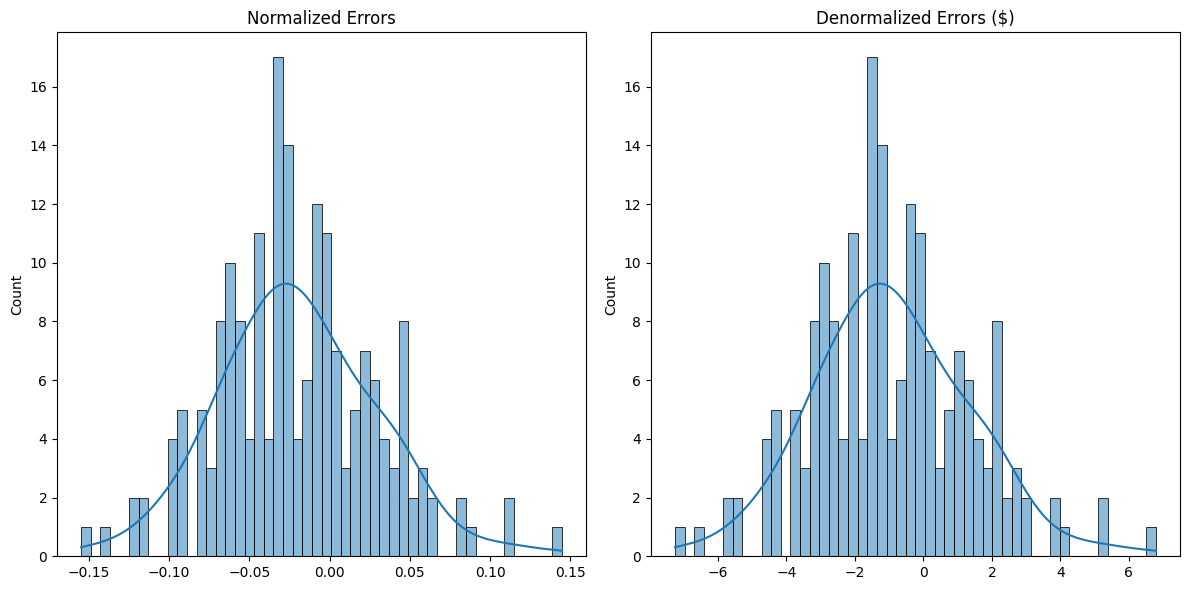

In [69]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch

# Assuming you have your scaler object saved during training
# If not, you'll need to recreate it with the original data range
# Example for MinMaxScaler (adjust if you used StandardScaler):
# scaler = MinMaxScaler()
# scaler.min_, scaler.scale_ = your_saved_min, your_saved_scale

# Define the loss function
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_predictions = []
all_ground_truth = []

# Initialize total test loss
total_test_loss = 0

# Disable gradient calculation
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Extract the last closing price from input sequence
        last_closing = x_batch[:, -1, 3]  # Shape: [batch_size]
        
        # Create decoder input
        decoder_input = torch.zeros(x_batch.size(0), PRED_LENGTH, 1, device=device)
        decoder_input[:, 0, 0] = last_closing  # Set first time step's feature
        
        # Forward pass
        encoder_output = model['encoder'](x_batch)
        predictions, _ = model['decoder'](decoder_input, encoder_output)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader.dataset)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# Flatten for metrics calculation
y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Calculate metrics with error handling
try:
    # Normalized metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # PROPER DENORMALIZATION USING YOUR SCALER PARAMETER
    target_scaler = joblib.load('target_scaler.pkl')

    # Print scaler stats (verify)
    print(f"Original mean: ${target_scaler.mean_[0]:.2f}")
    print(f"Original std: ${target_scaler.scale_[0]:.2f}")
    original_std=target_scaler.scale_[0]
    original_mean=target_scaler.mean_[0]
    y_true_denorm = (y_true * original_std) + original_mean
    y_pred_denorm = (y_pred * original_std) + original_mean

    # Denormalized metrics
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    
    # Improved MAPE calculation (ignore prices < $5 to avoid extreme percentages)
    valid_mask = y_true_denorm > 5.0
    mape_denorm = np.mean(np.abs((y_true_denorm[valid_mask] - y_pred_denorm[valid_mask]) / 
                         y_true_denorm[valid_mask])) * 100

    # Plotting with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAPL Stock Prediction\nTrue Range: ${df['Close'].min():.2f}-${df['Close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nNormalized Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f} ({(rmse_denorm/original_mean)*100:.1f}% of mean price)")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE (>$5 prices): {mape_denorm:.2f}%")

except Exception as e:
    print(f"Error: {str(e)}")

except Exception as e:
    print(f"Error calculating metrics: {str(e)}")

# Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(y_true, y_pred)
    sns.heatmap(correlation_matrix, annot=True, 
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Correlation Between Actual and Predicted Values')
    plt.show() 

    # Calculate absolute errors for each prediction day
    abs_errors = np.abs(all_predictions - all_ground_truth)
    mean_errors_by_day = np.mean(abs_errors, axis=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_errors_by_day.reshape(1, -1), 
            annot=True, fmt=".4f",
            cmap="YlOrRd",
            xticklabels=[f"Day {i+1}" for i in range(mean_errors_by_day.shape[0])],
            yticklabels=['MAE'])
    plt.title('Mean Absolute Error by Prediction Day')
    plt.show() 

    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")